In [261]:


#library functions
def reduce_and_plot_clusters(X, model, title=""):
    X_reduced = TruncatedSVD().fit_transform(X)
    X_embedded = TSNE(learning_rate=100).fit_transform(X_reduced)

    n_clus = len(set(model.labels_.tolist()))

    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x",
                c=model.labels_.tolist(), cmap=plt.cm.get_cmap("prism", n_clus))
    plt.colorbar(ticks=range(n_clus))
    plt.clim(-0.5, (n_clus - 0.5))
    plt.savefig('i/reduce_and_plot_clusters' +
                str(datetime.datetime.now()) + '.png')
    plt.show()

    
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
            
    plt.show()
    
    return ddata

# GAC

In [262]:
import json
import operator
import itertools
import pandas as pd
import scipy as sp
import numpy as np
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import fcluster
figsize(10,8)

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [7]:
file_num = [35, 30]
# file_num = [35]

In [8]:
data = []
for f in file_num: 
    print f
    with open("../datasets/raw-data/"+str(f)+".json", 'rb') as infile:
        data.extend(json.load(infile))

35
30


In [9]:
print len(data)

58


# pre-process (entities)

In [243]:
# stories = [doc["_source"]["content"] for doc in data]
# times = [doc]
# ids = [doc["_id"] for doc in data]

def format_entities(norm_ent):
    ents = []
    for ent in norm_ent:
        try:
            ents.append(ent['surface-form'])
        except:
            continue
    return " ".join(ents)

d = [{"id": doc["_id"],
  "first-published": doc["_source"]["first-published"],
  "title": doc["_source"]["title"],
  "summary": doc["_source"]["title"],
  "content": doc["_source"]["content"],
  "entities": format_entities(doc["_source"]["normalised-entities"])} for doc in data]


            

df_story = pd.DataFrame(d)



In [245]:
df_story['first-published-epoch'] = df_story['first-published'].apply(lambda x : int(datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").strftime("%s")))

In [246]:
df_story_sort = df_story.sort_values(by='first-published-epoch')

In [247]:
df_story_sort.head(10)

,content,entities,first-published,id,summary,title,first-published-epoch
9,Partners Group anticipates secondaries pricing...,Partners Group,2015-08-31T00:00:00Z,225f3ef1-88be-41b4-8aab-3e12b42aef83,"Partners Group cautious on PE, overweight RE i...","Partners Group cautious on PE, overweight RE i...",1440975600
11,Partners Group has been investing in real esta...,Partners Group Zug Norway,2015-08-31T00:00:00Z,2e021cc0-8589-4e33-9ec9-357f0ab3e099,Partners: Non-traditional RE secondary deals o...,Partners: Non-traditional RE secondary deals o...,1440975600
44,"Sep 01, 2015( Jewish Business News: http://jew...",Johnston Press Deal Israeli 02 Portsmouth YouT...,2015-09-01T00:00:00Z,78196621-1340-43ab-9ee2-61864cb10e70,UK Publisher Johnston Press Launches Exclusive...,UK Publisher Johnston Press Launches Exclusive...,1441062000
50,World News: 08:00 GMT Tuesday 1st September 20...,Johnston Press Deal Thomson Reuters Portsmouth...,2015-09-01T07:00:43Z,9d633317-7716-448e-bf4b-9a8eff6642ff,Leading UK Publisher Johnston Press Launches E...,Leading UK Publisher Johnston Press Launches E...,1441087243
38,Johnston Press has agreed a multi-year partner...,Johnston Press,2015-09-01T09:36:36Z,916f3424-854a-4f88-a72e-ccbcd77d6b06,Johnston Press agrees multi-year content deal ...,Johnston Press agrees multi-year content deal ...,1441096596
29,"Taboola, a “content discovery platform”, gener...",Johnston Press Moriarty,2015-09-01T10:59:46Z,f1d47549-5f69-46e2-8446-b8d95bff5bf6,Johnston Press agrees partnership with content...,Johnston Press agrees partnership with content...,1441101586
32,"Taboola , the leading discovery platform, toda...",Johnston Press Portsmouth YouTube comScore Adam,2015-09-01T15:56:22Z,b87c4791-ddef-47c2-802f-e665a44c3abd,Johnston Press announces multi-year deal with ...,Johnston Press announces multi-year deal with ...,1441119382
8,The Swiss private markets investment manager h...,Partners Group Nordic Swiss,2015-09-02T00:00:00Z,94a8cbfa-cd77-4654-a701-8412d7598551,Partners Group buys Nordic real estate portfolio,Partners Group buys Nordic real estate portfolio,1441148400
19,"AP3, Sweden's third national pension fund, has...",Sweden Eskilstuna Halmstad Karlskrona Swedish ...,2015-09-02T00:00:00Z,ccaf4766-12ce-401e-aae2-1c1d2b81b82b,"AP3 enters office, retail property joint ventu...","AP3 enters office, retail property joint ventu...",1441148400
12,"Sveafastigheter, which is part of Brunswick Re...",Partners Group Nordic Brunswick Sweden Finland...,2015-09-02T00:00:00Z,4a23c921-c6a7-4bde-9ea9-c260542cb71e,Partners Group buys Nordic real estate portfolio,Partners Group buys Nordic real estate portfolio,1441148400


In [248]:
df_story_sort.tail(10)

,content,entities,first-published,id,summary,title,first-published-epoch
52,Euronews Names Exclusive Discovery Partner to ...,Euronews Discovery Europe global news YouTube ...,2015-10-14T08:00:00Z,1a16243e-73c1-4670-9711-5587291b66a0,Euronews Names Taboola Exclusive Discovery Par...,Euronews Names Taboola Exclusive Discovery Par...,1444806000
25,France-based multi-lingual news channel Eurone...,Euronews comScore,2015-10-14T11:49:28Z,16d363c9-d2d4-4c4d-91fe-d7c6d14e6171,Euronews picks Taboola for online content reco...,Euronews picks Taboola for online content reco...,1444819768
10,It was a busy summer for secondaries and the f...,HarbourVest Partners Blackstone LGT Capital Pa...,2015-10-19T00:00:00Z,c02fac78-8c29-4dd0-a151-9d780408e4a1,Fundraising soars during summer,Fundraising soars during summer,1445209200
31,Taboola has partnered with NDTV Convergence to...,NDTV Indian Bangkok Adam,2015-10-19T14:57:39Z,caa596a3-f3a4-405f-bfc9-ce49bc236048,Taboola signs up to drive content discovery fo...,Taboola signs up to drive content discovery fo...,1445263059
15,Partners Group has acquired a portfolio of tai...,Partners Group Finnish Graphite Capital Michel...,2015-10-21T00:00:00Z,82a2e56a-39ba-41ca-b87f-fdd583827704,Partners Group buys portfolio of stakes from Keva,Partners Group buys portfolio of stakes from Keva,1445382000
42,"BANGKOK, Oct. 21, 2015 (GLOBE NEWSWIRE) -- T...",Thailand BANGKOK Adam The Weather Channel Pasa...,2015-10-21T03:52:33Z,9d48d4a7-39b5-4bc3-b335-e49b88fb48a2,Taboola Launches Thai Language - Brings Conten...,Taboola Launches Thai Language - Brings Conten...,1445395953
27,"BANGKOK: Taboola, the leading discovery platfo...",BANGKOK Thailand Adam Chicago Tribune The Weat...,2015-10-22T10:05:00Z,db95ceb0-ac2e-4109-b014-b8f8a0122f65,"Taboola launches Thai language drive, brings c...","Taboola launches Thai language drive, brings c...",1445504700
2,A boom from Japanese institutional investors b...,Japanese Mark Evans Africa London Paris Milan ...,2015-10-27T00:00:00Z,5e073c47-ec91-496e-acc5-7228b9cde371,Japanese pensions to invest in RE secondaries,Japanese pensions to invest in RE secondaries,1445904000
53,SOURCE InMobi; Taboola\n\nGlobal Partnership E...,InMobi SAN FRANCISCO comScore Adam Twitter,2015-10-29T12:01:00Z,a2e52310-0cbe-4095-aab6-54509ebe1cb7,InMobi and Taboola Partner To Engage Over One ...,InMobi and Taboola Partner To Engage Over One ...,1446120060
37,Ad-tech companies InMobi and Taboola announced...,InMobi comScore China India North America Adam...,2015-10-29T12:53:02Z,866232ec-bf55-4ebc-90c1-159f94c3df6f,Taboola Partners InMobi to Bring Content Disco...,Taboola Partners InMobi to Bring Content Disco...,1446123182


## gac params

b: bucket size (limits scope of the GAC clustering)
p: reduction factor (i.e 100 clusters becomes 50 clusters)
s: min similarity threshold (for two clusters to be combined)
t: number of terms to keep per cluster prototype
term weighting: how to vectorize (i.e "ltc", from SMART weighting scheme)
re: # of iterations between re-clustering 

Input: Sorted stories + Params
Output: Forest of binary tree clusters

### basic gac - greedy, bottom-up

n_clus_init = parition size


repeat until most similar < s or n_clus > n_clus_init/p
    - compute document similarity matrix
    - calculate most similar
    - pair most similar documents

### temporal gac

- sort stories
- let sort be initial partition
- repeat until most similar < s or n_clus < b (iterator val: i)
    if i % k == 0 && i != 0
        - apply gac
    else
    - divide partition into 'b' buckets (non-overlapping and consecutive)
    - apply gac
    - remove bucket boundaries
    



In [249]:
# params

b = 10
p = 0.5
s = 0.2
t = 100
# term weighting = "ltc" # possible through sklearn
re = 5

from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(use_idf=True, norm='l2', sublinear_tf=True)
vsm = vect.fit_transform(df_story["content"].values)

vsm_arr = vsm.toarray()

df_story['vsm'] = [r for r in vsm_arr]

# def gac


In [250]:
df_story.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 8 columns):
content                  58 non-null object
entities                 58 non-null object
first-published          58 non-null object
id                       58 non-null object
summary                  58 non-null object
title                    58 non-null object
first-published-epoch    58 non-null int64
vsm                      58 non-null object
dtypes: int64(1), object(7)
memory usage: 4.1+ KB


In [251]:
vsm.shape

(58, 2784)

In [252]:
df_story

,content,entities,first-published,id,summary,title,first-published-epoch,vsm
0,A host of pure-play and multi-strategy manager...,Hong Kong China India Japan Merrill Lynch Harb...,2015-09-08T16:39:00Z,8909a76f-4c19-4b3d-b58a-9e6db917ce40,Asia secondaries: Worth the wait?,Asia secondaries: Worth the wait?,1441726740,"[0.0, 0.0481055108076, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,Rising prices in the European infrastructure s...,Pantheon London Partners Group,2015-09-09T00:00:00Z,f45fa173-cfb3-4cd7-b8cf-9f4470130b23,Pricing for European infra secondaries to stab...,Pricing for European infra secondaries to stab...,1441753200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,A boom from Japanese institutional investors b...,Japanese Mark Evans Africa London Paris Milan ...,2015-10-27T00:00:00Z,5e073c47-ec91-496e-acc5-7228b9cde371,Japanese pensions to invest in RE secondaries,Japanese pensions to invest in RE secondaries,1445904000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Real estate secondaries funds are chasing abou...,Landmark Partners Partners Group DLJ,2015-10-12T00:00:00Z,ce14a151-39a1-4ec0-bb50-039be6b883fc,Real estate secondaries funds target $2.34bn,Real estate secondaries funds target $2.34bn,1444604400,"[0.0, 0.0, 0.0, 0.0658944361999, 0.0, 0.0, 0.0..."
4,Private equity investors are increasingly worr...,HarbourVest Partners AlpInvest Partners Partne...,2015-09-18T00:00:00Z,93557c34-49fe-46a7-9d9b-567f1f99ad0f,Currency volatility a concern for secondaries ...,Currency volatility a concern for secondaries ...,1442530800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,The story was updated with spokeswoman's comme...,Partners Group Pennsylvania UK Australia,2015-09-08T00:00:00Z,e21d4298-ba54-4f9f-ae99-045561d56e99,Partners holds first close on 6th secondaries ...,Partners holds first close on 6th secondaries ...,1441666800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0825576226756..."
6,The market for real estate secondaries investm...,Partners Group India,2015-09-10T00:00:00Z,7fc01584-5679-4cfd-9d8a-76f96e0ba984,Asian RE secondaries deal volume to pick up,Asian RE secondaries deal volume to pick up,1441839600,"[0.0, 0.0, 0.0, 0.0630569788831, 0.0, 0.0, 0.0..."
7,Partners Group has bought a portfolio of US pr...,Partners Group DLJ New York Tennessee California,2015-10-01T00:00:00Z,88b1f076-8195-41a8-9a86-585e17d903dc,Partners Group buys US property portfolio thro...,Partners Group buys US property portfolio thro...,1443654000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,The Swiss private markets investment manager h...,Partners Group Nordic Swiss,2015-09-02T00:00:00Z,94a8cbfa-cd77-4654-a701-8412d7598551,Partners Group buys Nordic real estate portfolio,Partners Group buys Nordic real estate portfolio,1441148400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,Partners Group anticipates secondaries pricing...,Partners Group,2015-08-31T00:00:00Z,225f3ef1-88be-41b4-8aab-3e12b42aef83,"Partners Group cautious on PE, overweight RE i...","Partners Group cautious on PE, overweight RE i...",1440975600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [253]:
df_story.loc[52]['vsm']

array([ 0.04584,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ])

## GAC (with stopping critera)

In [254]:
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
%matplotlib inline

In [255]:
Z = linkage(vsm_arr, method='average', metric='cosine')

In [256]:
#cophenet test
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

In [257]:
zip(range(0,58), Z)

[(0, array([ 20.,  21.,   0.,   2.])),
 (1, array([ 54.     ,  56.     ,   0.02201,   2.     ])),
 (2, array([ 28.     ,  41.     ,   0.03125,   2.     ])),
 (3, array([ 27.     ,  42.     ,   0.04328,   2.     ])),
 (4, array([ 55.     ,  57.     ,   0.10167,   2.     ])),
 (5, array([ 39.     ,  60.     ,   0.14903,   3.     ])),
 (6, array([ 23.     ,  48.     ,   0.19661,   2.     ])),
 (7, array([ 47.     ,  63.     ,   0.20173,   4.     ])),
 (8, array([ 32.     ,  50.     ,   0.22545,   2.     ])),
 (9, array([ 62.     ,  65.     ,   0.23551,   6.     ])),
 (10, array([ 16.     ,  22.     ,   0.32945,   2.     ])),
 (11, array([ 44.     ,  66.     ,   0.33813,   3.     ])),
 (12, array([ 24.     ,  38.     ,   0.36848,   2.     ])),
 (13, array([ 36.     ,  64.     ,   0.39675,   3.     ])),
 (14, array([  7.     ,  14.     ,   0.41891,   2.     ])),
 (15, array([ 69.     ,  70.     ,   0.42296,   5.     ])),
 (16, array([ 35.     ,  67.     ,   0.43407,   7.     ])),
 (17, arra

In [258]:
n = vsm.shape[0]
print n

def get_linkage_matrix(vsm):
    Z = linkage(vsm.toarray(), method='average', metric='cosine')
    c, coph_dists = cophenet(Z, pdist(vsm.toarray()))
    print "cophenet test: ", c
    return Z

def get_cluster_size(vsm, Z):
    for i, z in enumerate(Z):
#         print i, z
        if z[2] > 0.8 :
            print i, ": Min similarity reached"
            print Z[i]
            n_clus = n - i
            break
        if n * 0.5 == i:
            print i, ": Max reduction reached"
            print Z[i]
            n_clus = n - i
            break
            
    return n_clus
        
n_clus = get_cluster_size(vsm, get_linkage_matrix(vsm))
    
print "n_clus: ", n_clus
        
    

58
cophenet test:  0.938680052662
29 : Max reduction reached
[  9.       11.        0.62337   2.     ]
n_clus:  29


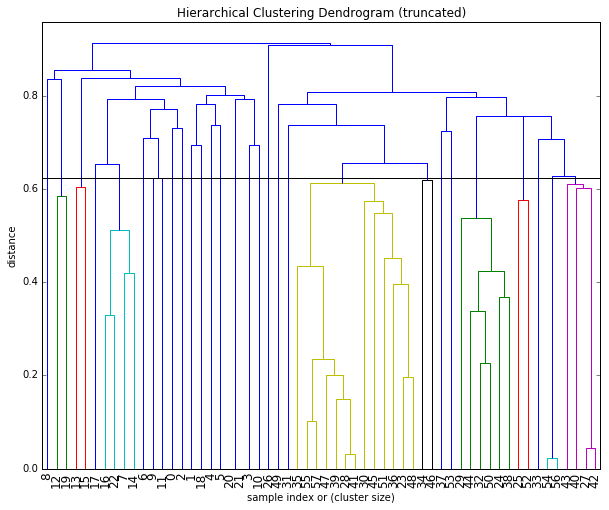

In [263]:
ddata = fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=58,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d = 0.62337 # useful in small plots so annotations don't overlap
)

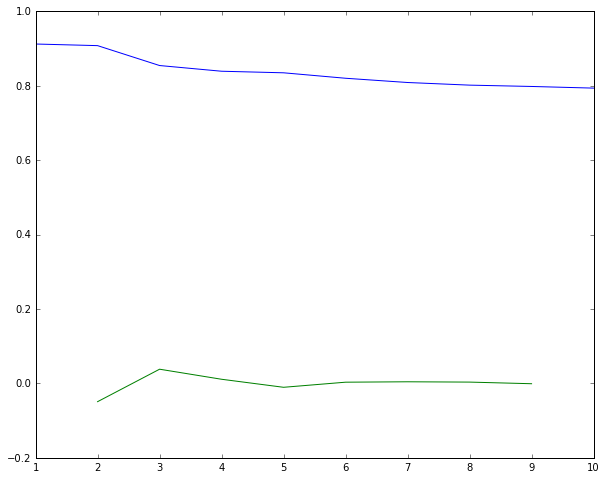

clusters: 3


In [264]:

last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k

In [265]:
clusters = fcluster(Z, n_clus, criterion='maxclust')
clusters

array([ 9, 11, 10, 16, 13, 14,  8,  4,  2,  6, 17,  7,  1,  3,  4,  3,  4,
        5, 12,  1, 15, 15,  4, 18, 24, 25, 29, 27, 18, 24, 18, 20, 24, 28,
       19, 18, 18, 22, 24, 18, 27, 18, 27, 27, 24, 18, 19, 18, 18, 21, 24,
       18, 25, 23, 26, 18, 26, 18], dtype=int32)

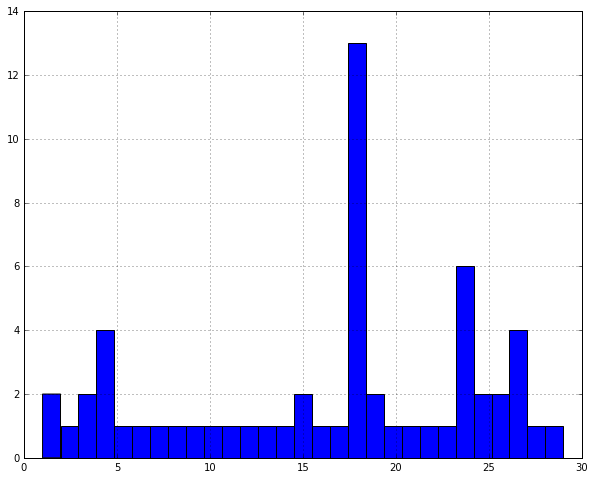

In [266]:
pd.Series(clusters).hist(bins=len(np.unique(clusters)))

In [267]:
df_story['cluster'] = clusters

In [268]:
df_story

,content,entities,first-published,id,summary,title,first-published-epoch,vsm,cluster
0,A host of pure-play and multi-strategy manager...,Hong Kong China India Japan Merrill Lynch Harb...,2015-09-08T16:39:00Z,8909a76f-4c19-4b3d-b58a-9e6db917ce40,Asia secondaries: Worth the wait?,Asia secondaries: Worth the wait?,1441726740,"[0.0, 0.0481055108076, 0.0, 0.0, 0.0, 0.0, 0.0...",9
1,Rising prices in the European infrastructure s...,Pantheon London Partners Group,2015-09-09T00:00:00Z,f45fa173-cfb3-4cd7-b8cf-9f4470130b23,Pricing for European infra secondaries to stab...,Pricing for European infra secondaries to stab...,1441753200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11
2,A boom from Japanese institutional investors b...,Japanese Mark Evans Africa London Paris Milan ...,2015-10-27T00:00:00Z,5e073c47-ec91-496e-acc5-7228b9cde371,Japanese pensions to invest in RE secondaries,Japanese pensions to invest in RE secondaries,1445904000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10
3,Real estate secondaries funds are chasing abou...,Landmark Partners Partners Group DLJ,2015-10-12T00:00:00Z,ce14a151-39a1-4ec0-bb50-039be6b883fc,Real estate secondaries funds target $2.34bn,Real estate secondaries funds target $2.34bn,1444604400,"[0.0, 0.0, 0.0, 0.0658944361999, 0.0, 0.0, 0.0...",16
4,Private equity investors are increasingly worr...,HarbourVest Partners AlpInvest Partners Partne...,2015-09-18T00:00:00Z,93557c34-49fe-46a7-9d9b-567f1f99ad0f,Currency volatility a concern for secondaries ...,Currency volatility a concern for secondaries ...,1442530800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",13
5,The story was updated with spokeswoman's comme...,Partners Group Pennsylvania UK Australia,2015-09-08T00:00:00Z,e21d4298-ba54-4f9f-ae99-045561d56e99,Partners holds first close on 6th secondaries ...,Partners holds first close on 6th secondaries ...,1441666800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0825576226756...",14
6,The market for real estate secondaries investm...,Partners Group India,2015-09-10T00:00:00Z,7fc01584-5679-4cfd-9d8a-76f96e0ba984,Asian RE secondaries deal volume to pick up,Asian RE secondaries deal volume to pick up,1441839600,"[0.0, 0.0, 0.0, 0.0630569788831, 0.0, 0.0, 0.0...",8
7,Partners Group has bought a portfolio of US pr...,Partners Group DLJ New York Tennessee California,2015-10-01T00:00:00Z,88b1f076-8195-41a8-9a86-585e17d903dc,Partners Group buys US property portfolio thro...,Partners Group buys US property portfolio thro...,1443654000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
8,The Swiss private markets investment manager h...,Partners Group Nordic Swiss,2015-09-02T00:00:00Z,94a8cbfa-cd77-4654-a701-8412d7598551,Partners Group buys Nordic real estate portfolio,Partners Group buys Nordic real estate portfolio,1441148400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
9,Partners Group anticipates secondaries pricing...,Partners Group,2015-08-31T00:00:00Z,225f3ef1-88be-41b4-8aab-3e12b42aef83,"Partners Group cautious on PE, overweight RE i...","Partners Group cautious on PE, overweight RE i...",1440975600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",6


In [269]:
cluster_order_dict = {}
cluster_order_list = []
for i, z in enumerate(Z):
    cluster_order_dict[z[0]] = 2 * i
    cluster_order_dict[z[1]] = 2 * i + 1
    cluster_order_list.extend([z[0], z[1]])

print cluster_order_dict
print cluster_order_list



{0.0: 76, 1.0: 66, 2.0: 77, 3.0: 68, 4.0: 80, 5.0: 81, 6.0: 72, 7.0: 28, 8.0: 104, 9.0: 58, 10.0: 69, 11.0: 59, 12.0: 46, 13.0: 50, 14.0: 29, 15.0: 51, 16.0: 20, 17.0: 62, 18.0: 67, 19.0: 47, 20.0: 0, 21.0: 1, 22.0: 21, 23.0: 12, 24.0: 24, 25.0: 44, 26.0: 110, 27.0: 6, 28.0: 4, 29.0: 38, 30.0: 42, 31.0: 78, 32.0: 16, 33.0: 70, 34.0: 56, 35.0: 32, 36.0: 26, 37.0: 74, 38.0: 25, 39.0: 10, 40.0: 48, 41.0: 5, 42.0: 7, 43.0: 52, 44.0: 22, 45.0: 40, 46.0: 57, 47.0: 14, 48.0: 13, 49.0: 90, 50.0: 17, 51.0: 34, 52.0: 45, 53.0: 75, 54.0: 2, 55.0: 8, 56.0: 3, 57.0: 9, 58.0: 94, 59.0: 60, 60.0: 11, 61.0: 49, 62.0: 18, 63.0: 15, 64.0: 27, 65.0: 19, 66.0: 23, 67.0: 33, 68.0: 36, 69.0: 30, 70.0: 31, 71.0: 35, 72.0: 37, 73.0: 39, 74.0: 54, 75.0: 41, 76.0: 63, 77.0: 84, 78.0: 43, 79.0: 55, 80.0: 82, 81.0: 105, 82.0: 53, 83.0: 106, 84.0: 61, 85.0: 64, 86.0: 65, 87.0: 73, 88.0: 71, 89.0: 92, 90.0: 79, 91.0: 88, 92.0: 95, 93.0: 83, 94.0: 86, 95.0: 96, 96.0: 87, 97.0: 91, 98.0: 89, 99.0: 85, 100.0: 97, 101.

In [298]:
for name, group in df_story.groupby('cluster'):
    print "name: ", name, "group len: ", len(group)
    if len(group) > 1:
        print "AVERAGE LOGIC:"
        idx = group.index.values
        print idx
#         print i
        order = [cluster_order_dict[i] for i in idx] 
        idx_order = sorted(zip(idx, order), key=lambda x: x[1])
        idx_order = [list(el) for el in idx_order]
#         print df_story.loc[idx_order[0][0]]['first-published-epoch']
        time_vector = [df_story.loc[i[0]]['first-published-epoch'] for i in idx_order]
        vsm_vector = [df_story.loc[i[0]]['vsm'] for i in idx_order]
        print "BEFORE PROCESSING"
        print idx_order
        print time_vector
        print vsm_vector
        
        # pair pairs i, j, where j = i+1
        # also update time_vector, vsm_vector
        
        for i, el in enumerate(idx_order):
            if i + 1 < len(idx_order):
                j = i + 1
                if idx_order[i][1] == idx_order[j][1] - 1:
#                     print "pair found: ", idx_order[i][0], idx_order[j][0]
                    idx_order[i][0] = [idx_order[i][0], idx_order[j][0]]
                    idx_order[i][1] = np.mean([idx_order[i][1], idx_order[j][1]])
                    
                    idx_order.pop(j)
                    
                    time_vector[i] = np.mean([time_vector[i], time_vector[j]])
                    
                    time_vector.pop(j)
                    
#                     print type(vsm_vector[0]), type(vsm_vector[1])
                    
                    vsm_vector[i] = np.mean(np.array([vsm_vector[i], vsm_vector[j]]), axis=0)
                    vsm_vector.pop(j)
             
        print
#         print "midway idx_order"
#         print idx_order
#         print
        
        i = 0
        j = 1
            
        while len(idx_order) > 1:
#             print "merge pair: ", idx_order[i][0], idx_order[j][0]
            idx_order[i][0] = [idx_order[i][0], idx_order[j][0]]
            idx_order[i][1] = np.mean([idx_order[i][1], idx_order[j][1]])

            idx_order.pop(j)

            time_vector[i] = np.mean([time_vector[i], time_vector[j]])

            time_vector.pop(j)



#             print type(vsm_vector[0]), type(vsm_vector[1])

            vsm_vector[i] = np.mean(np.array([vsm_vector[i], vsm_vector[j]]), axis=0)
            vsm_vector.pop(j)

#             print idx_order
                
                    
        # perform remaining averageing

                    
        print "AFTER PROCESSING"
        print idx_order
        print time_vector
        print vsm_vector
        
        print
        print
        print

name:  1 group len:  2
AVERAGE LOGIC:
[12 19]
BEFORE PROCESSING
[[12, 46], [19, 47]]
[1441148400, 1441148400]
[array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([ 0.     ,  0.     ,  0.07186, ...,  0.     ,  0.07186,  0.07186])]

AFTER PROCESSING
[[[12, 19], 46.5]]
[1441148400.0]
[array([ 0.     ,  0.     ,  0.03593, ...,  0.     ,  0.03593,  0.03593])]



name:  2 group len:  1
name:  3 group len:  2
AVERAGE LOGIC:
[13 15]
BEFORE PROCESSING
[[13, 50], [15, 51]]
[1444086000, 1445382000]
[array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([ 0.,  0.,  0., ...,  0.,  0.,  0.])]

AFTER PROCESSING
[[[13, 15], 50.5]]
[1444734000.0]
[array([ 0.,  0.,  0., ...,  0.,  0.,  0.])]



name:  4 group len:  4
AVERAGE LOGIC:
[ 7 14 16 22]
BEFORE PROCESSING
[[16, 20], [22, 21], [7, 28], [14, 29]]
[1443672151, 1443654000, 1443654000, 1443685638]
[array([ 0.07416,  0.     ,  0.     , ...,  0.06411,  0.     ,  0.     ]), array([ 0.05088,  0.     ,  0.     , ...,  0.07448,  0.     ,  0.     ]), array([ 0.,

In [192]:
print type(time_vector[0])

<type 'unicode'>


In [191]:
time_vector[0]

u'2015-10-22T10:05:00Z'

In [193]:
np.mean(time_vector[0], time_vector[1])

TypeError: tuple indices must be integers, not unicode

In [199]:
from datetime import datetime
import time

In [198]:
time.mktime(strptime(time_vector[0, "%Y-%m-%dT%").timetuple())
print type(time_vector[0])

<type 'unicode'>


In [200]:
time_vector[0]

u'2015-10-22T10:05:00Z'

In [210]:
datetime.strptime(time_vector[0], "%Y-%m-%dT%H:%M:%SZ").strftime("%s")

'1445504700'

In [241]:
print type(time_vector[0]), type(time_vector[1])

<type 'str'> <type 'str'>


In [271]:
print type(vsm_vector[0]), type(vsm_vector[1])

<type 'numpy.float64'> <type 'numpy.ndarray'>


In [282]:
idx_order

[[[27, 42], 6.5], [40, 48], [43, 52]]

In [284]:
idx_order[1:]

[[40, 48], [43, 52]]